In [1]:
import numpy as np
from gym.utils import seeding
from gym import spaces
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.utils import get_schedule_fn
import matplotlib.pyplot as plt
import pandas as pd
import talib

2023-06-20 05:03:59.998009: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def feature_engineering(df):
    open = df['open'].values
    high = df['high'].values
    low = df['low'].values
    close = df['close'].values
    # volume = df['volume'].values
    hilo = (high + low) / 2

    df['RSI8'] = talib.RSI(close, timeperiod=8) # default = 14
    df['RSI14'] = talib.RSI(close, timeperiod=14)
    df['RSI_ST'] = talib.RSI(close)/close
    df['RSI_LOG'] = log_transform_feature(talib.RSI(close))
    df['MACD'], _, _ = talib.MACD(close)
    df['MACD_ST'], _, _ = talib.MACD(close)/close
    df['ATR'] = talib.ATR(high, low, close)
    
    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['+DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['-DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    
    df['SMA15'] = talib.SMA(close, timeperiod=15) # 15分足
    df['SMA300'] = talib.SMA(close, timeperiod=300) # 15分足20MA
    
    df['BB_UPPER'], df['BB_MIDDLE'], df['BB_LOWER'] = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] = (df['BB_UPPER'] - hilo) / close
    df['BBANDS_middleband'] = (df['BB_MIDDLE'] - hilo) / close
    df['BBANDS_lowerband'] = (df['BB_LOWER'] - hilo) / close

    df['STOCH_K'], df['STOCH_D'] = talib.STOCH(high, low, close)/close
    df['MON'] = talib.MOM(close, timeperiod=5)

    df['pinbar'] = pinbar(df)
    df['RCI'] = df['close'].rolling(9).apply(calc_rank_correlation)

    df = df.fillna(method='ffill')
    df = df.dropna()

    return df

def pinbar(df):
    body = np.abs(df['close'] - df['open'])
    upper_wick = df['high'] - np.max(df[['open', 'close']], axis=1)
    lower_wick = np.min(df[['open', 'close']], axis=1) - df['low']
    total_length = df['high'] - df['low']
    
    # 上向きのピンバー（ロングサイン）:下ワックが本体の3倍以上、上ワックが全体の長さの20~30%以内
    is_bullish_pinbar = (lower_wick >= 3 * body) & (upper_wick <= total_length * 0.3)
    
    # 下向きのピンバー（ショートサイン）:上ワックが本体の3倍以上、下ワックが全体の長さの20~30%以内
    is_bearish_pinbar = (upper_wick >= 3 * body) & (lower_wick <= total_length * 0.3)
    
    # 上向きピンバー = 1、下向きピンバー = 2、ピンバーでない = 0
    return np.where(is_bullish_pinbar, 1, np.where(is_bearish_pinbar, 2, 0))

def calc_rank_correlation(series):
    n = len(series)
    ranks = series.rank()
    sum_diffs_squared = sum((ranks - np.arange(n) - 1) ** 2)
    return 1 - 6 * sum_diffs_squared / (n * (n ** 2 - 1))

def log_transform_feature(X):
    X[X <= 0] = np.finfo(float).eps
    return np.log(X)

In [12]:
class TradingEnv(gym.Env):
    def __init__(self, df):
        super(TradingEnv, self).__init__()

        self.df = df
        self.reward_range = (-np.inf, np.inf)
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(len(self.df.columns) + 2,))

        # Add history for plotting and reward calculation
        self.history = []
        self.returns = []

    def step(self, action):
        done = False
        obs = self.df.iloc[self.current_step]
        
        previous_total_asset = self.cash + self.holdings * obs['close']

        if action == 0: # Hold
            pass
        elif action == 1: # Buy
            if self.holdings == 0:
                self.cash -= obs['close']
                self.holdings += 1
        elif action == 2:  # Sell
            if self.holdings > 0:
                self.cash += obs['close']
                self.holdings -= 1

        total_asset = self.cash + self.holdings * obs['close']
        self.returns.append(total_asset - previous_total_asset)

        if len(self.returns) > 1:
            returns_np = np.array(self.returns)
            std_dev = np.std(returns_np)
            std_dev = max(std_dev, 1e-8)  # Avoid division by zero or very small number
            reward = np.mean(returns_np) / std_dev
        else:
            reward = 0


        self.current_step += 1

        if self.current_step >= len(self.df):
            done = True

        # Save results for plotting
        self.history.append({
            'step': self.current_step,
            'cash': self.cash,
            'action': action,
            'holdings': self.holdings,
            'total_asset': total_asset,
            'reward': reward
        })

        return np.append(obs, [self.holdings, self.cash]), reward, done, {}

    def reset(self):
        self.current_step = 0
        self.holdings = 0
        self.cash = 1000000

        # Reset history and returns
        self.history = []
        self.returns = []
        
        return np.append(self.df.iloc[self.current_step], [self.holdings, self.cash])

    # Additional function for plotting
    def plot_history(self):
        df_history = pd.DataFrame(self.history)
        df_history.set_index('step', inplace=True)

        fig, ax = plt.subplots(2, 1, sharex=True, figsize=[16, 9])

        ax[0].plot(df_history['cash'], label='Cash')
        ax[0].set_title('Cash')
        ax[0].legend(loc='upper left')

        ax[1].plot(df_history['action'], label='Action', linestyle='--')
        ax[1].set_title('Action')
        ax[1].legend(loc='upper left')

        plt.tight_layout()
        plt.show()
        
        fig, ax = plt.subplots(figsize=[16, 9])
        ax.plot(self.df.index, self.df['close'], label='Close Price')
        ax.set_title('Stock Price')
        ax.legend(loc='upper left')
        
        plt.show()


In [13]:
def evaluate(model, num_episodes=100):
    """
    評価関数
    """
    env = model.get_env()  # 環境の取得
    all_rewards = []  # 報酬を保存するリスト

    for i in range(num_episodes):
        obs = env.reset()  # 環境のリセット
        done = False
        total_reward = 0  # 累積報酬の初期化

        while not done:
            action, _ = model.predict(obs)  # 行動の選択
            obs, reward, done, _ = env.step(action)  # 環境のステップ
            total_reward += reward  # 報酬の累積

        all_rewards.append(total_reward)

    mean_reward = np.mean(all_rewards)  # 平均報酬の計算

    print(f"Mean reward: {mean_reward} +/- {np.std(all_rewards)}")

,date,open,high,low,close
0,0.0,4130.3,4132.3,4128.5,4128.9
1,60.0,4128.9,4130.0,4127.0,4128.6
2,120.0,4128.7,4129.3,4128.0,4128.4
3,180.0,4128.4,4129.3,4127.0,4129.2
4,240.0,4129.5,4132.0,4129.5,4130.4
...,...,...,...,...,...
9994,841740.0,4139.0,4140.7,4138.8,4140.2
9995,841800.0,4140.2,4140.4,4139.7,4139.7
9996,841860.0,4139.7,4140.0,4138.5,4139.7
9997,841920.0,4139.7,4141.2,4139.0,4140.9


/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_75550/3689334829.py:64: RuntimeWarning: invalid value encountered in log
  return np.log(X)


,date,open,high,low,close,RSI8,RSI14,RSI_ST,RSI_LOG,MACD,...,BB_MIDDLE,BB_LOWER,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,STOCH_K,STOCH_D,MON,pinbar,RCI
299,17940.0,4125.2,4125.2,4124.3,4124.7,48.606700,48.170026,0.011678,3.874737,-0.113139,...,4124.860,4123.964679,0.000244,0.000027,-0.000190,0.017527,0.017731,0.0,0,0.612500
300,18000.0,4124.7,4125.0,4124.7,4124.7,48.606700,48.170026,0.011678,3.874737,-0.109404,...,4124.835,4123.951201,0.000211,-0.000004,-0.000218,0.014987,0.017611,0.5,2,0.433333
301,18060.0,4124.8,4125.7,4124.8,4125.5,61.316004,55.877252,0.013544,4.023157,-0.041413,...,4124.850,4123.932394,0.000125,-0.000097,-0.000319,0.013830,0.015446,0.7,0,0.641667
302,18120.0,4125.5,4126.3,4125.4,4126.2,68.985688,61.300015,0.014856,4.115780,0.068168,...,4124.900,4123.817411,0.000032,-0.000230,-0.000493,0.017830,0.015547,1.5,0,0.675000
303,18180.0,4126.2,4126.3,4125.7,4126.0,64.791136,59.066366,0.014316,4.078662,0.137291,...,4124.915,4123.781378,0.000012,-0.000263,-0.000538,0.021467,0.017709,0.7,0,0.766667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,841740.0,4139.0,4140.7,4138.8,4140.2,76.148743,69.575328,0.016805,4.242410,2.042544,...,4135.260,4130.204547,0.000137,-0.001084,-0.002306,0.017512,0.018213,3.3,0,0.950000
9995,841800.0,4140.2,4140.4,4139.7,4139.7,71.065855,67.051416,0.016197,4.205460,2.096597,...,4135.580,4130.258121,0.000206,-0.001080,-0.002365,0.017282,0.017455,2.0,0,0.866667
9996,841860.0,4139.7,4140.0,4138.5,4139.7,71.065855,67.051416,0.016197,4.205460,2.115053,...,4135.820,4130.216929,0.000525,-0.000829,-0.002182,0.015982,0.016926,-0.1,1,0.745833
9997,841920.0,4139.7,4141.2,4139.0,4140.9,76.072438,70.073178,0.016922,4.249540,2.201136,...,4136.165,4130.213773,0.000487,-0.000950,-0.002387,0.016425,0.016560,2.2,0,0.745833


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_tensorboard/PPO_43
-----------------------------
| time/              |      |
|    fps             | 1100 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 876          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0001324919 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00033     |
|    n_updates            | 10           |
|    policy_gra

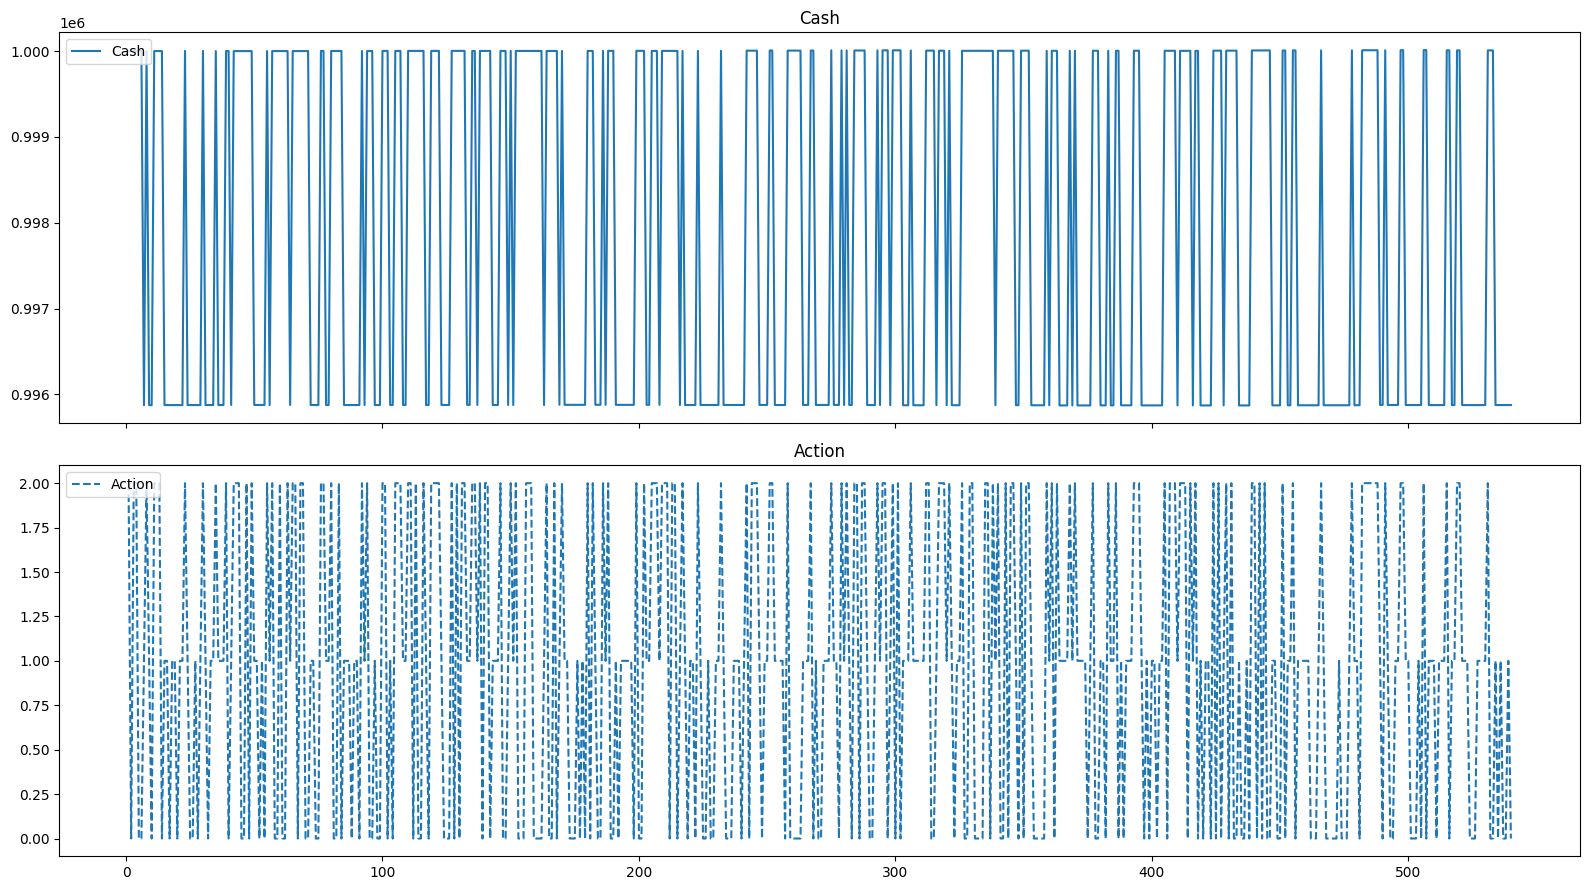

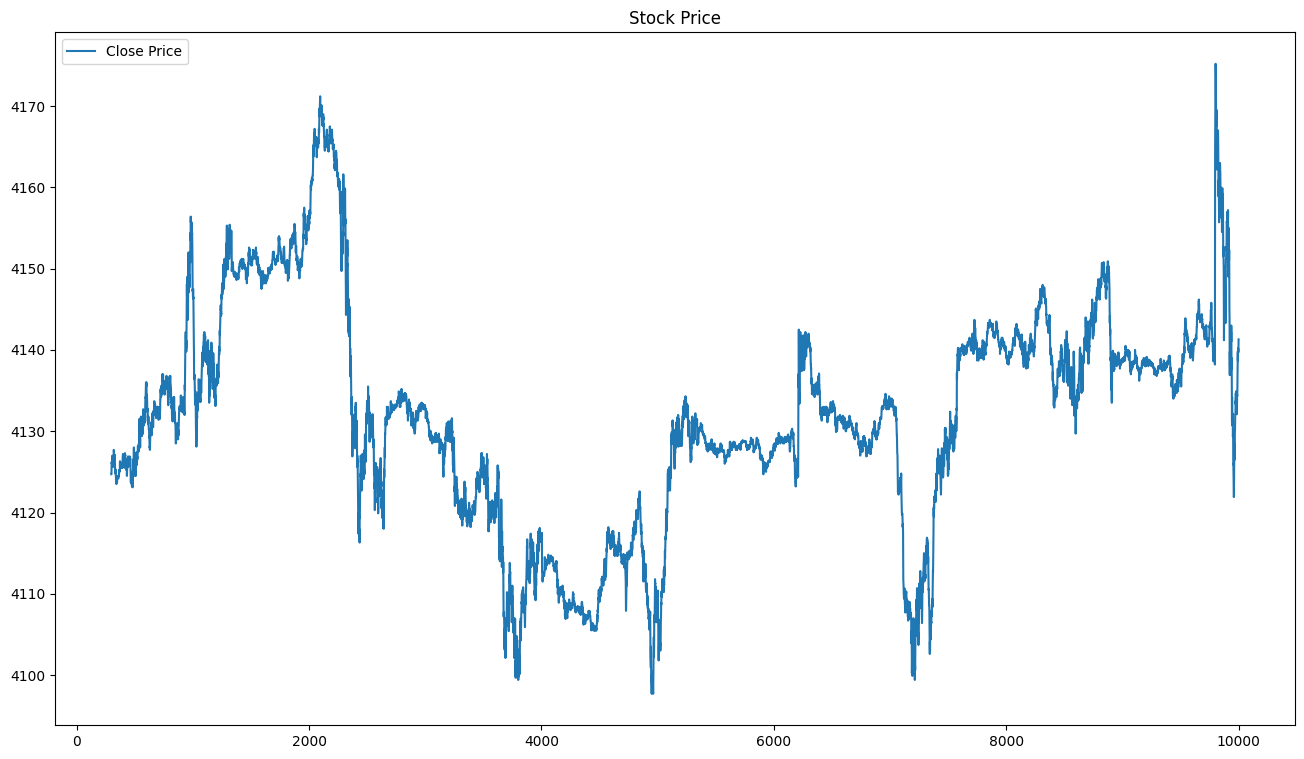

Mean reward: 0.0 +/- 0.0


/Users/tek/dev/python/gmo-algo-trading/myenv/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
  warnings.warn(
/Users/tek/dev/python/gmo-algo-trading/myenv/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


In [14]:
df = pd.read_csv('../csv/test_combined_data_10000.csv')

# 日付は文字列のまま読み込むことができないため、最小の日付からの経過秒数に変換
df['date'] = pd.to_datetime(df['date'])
df['date'] = (df['date'] - df['date'].min()).dt.total_seconds()
display(df)

df = feature_engineering(df)
display(df)

# create environment
env = TradingEnv(df)

# create agent with TensorBoard
model = PPO('MlpPolicy', env, verbose=1, tensorboard_log="./ppo_tensorboard/")

# train agent
model.learn(total_timesteps=10000)

# Plot the results
env.plot_history()

# evaluate model
evaluate(model, num_episodes=100)

model.save("../model/PPO_LONG")

from stable_baselines3.common.utils import get_schedule_fn

# モデルの読み込み
model = PPO.load("../model/PPO_LONG", clip_range=get_schedule_fn(0.2))

In [8]:
# clip_range の現在の値を取得
current_clip_range = model.clip_range(1.0)

print(current_clip_range)

0.2


In [24]:
print(df.columns)
print(f'columns number: {len(df.columns)}')

Index(['date', 'open', 'high', 'low', 'close', 'RSI8', 'RSI14', 'RSI_ST',
       'RSI_LOG', 'MACD', 'MACD_ST', 'ATR', 'ADX', 'ADXR', '+DI', '-DI',
       'SMA15', 'SMA300', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER',
       'BBANDS_upperband', 'BBANDS_middleband', 'BBANDS_lowerband', 'STOCH_K',
       'STOCH_D', 'MON', 'pinbar', 'RCI'],
      dtype='object')
columns number: 29
